# IBM Data Science Professinal Capstone Project: Which Neighborhood to Live in Toronto?

## Introduction/Business Problem

Toronto for a year to take care of the on-site implementation of our solution and training in customer environments.  Given that my role is required to travel 50%, I have better options in terms of choosing which neighborhood to live.  However I want to be able to easily access the coffee shops, cafés, and restaurants and very importantly I want to be close to yoga studio and gym for the workdays and the parks and/or natural scenes on the weekends. With these criteria in mind, I need to do neighborhoods analysis. I looked into location technology platform and found Foursquare provides the Places API that can enable neighborhood location discovery. 

This project aims to leverage the Foursquare location data to explore and compare neighborhoods of Toronto.  Just like most of problems data scientists target to solve, it meant to help a group of stakeholders, the audiences can include the long term travelers or business visitors and by applying the same methodology, when data sources are available, it can be for people who want to move to major city in the world.


## 1. Data Sources

The data used for this project includes the followings:
- The data set on Toronto neighborhood data is available on Wikipedia page. It is a list of postal codes in Toronto, Canada 
(NOTE: Postal codes beginning with M are located within the city of Toronto in the province of Ontario.) 
This [Toronto neighborhood data wiki page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) 
is performed web scrapping to extract the information to extract the information: Postcode, Borough and 
Neighborhood into a postal codes table
- List of Coordinates data set is required in order to utilize the Foursquare location data, the latitude 
and longitude coordinates of each postal code are obtained from List of Coordinates (http://cocl.us/Geospatial_data)
- Foursquare data set: Foursquare provides venues and their assigned categories information. Foursquare enables 
    developers to obtain these data points via Foursquare Place API; the Foursquare API is used 
    to explore and segment the neighborhoods

*__References__*:
1. Toronto neighborhood data on Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
2. List of Coordinates: http://cocl.us/Geospatial_data
3. Determining the number of clusters in a data set (elbow method): 
    https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set
4. Foursquare API endpoints from Foursquare Developers: https://developer.foursquare.com/docs/api/endpoints
5. Cluster Analysis: https://en.wikipedia.org/wiki/Cluster_analysis
6. K-means (decide the optimal number of clusters): https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set
7. Feature learning for machine learning: https://en.wikipedia.org/wiki/Feature_learning
8. A view on cities - Toronto:https://www.aviewoncities.com/toronto/queenspark.htm
9. Wiki Toronto: https://en.wikipedia.org/wiki/Toronto
10. Google maps: https://www.google.com/maps
<br/>

## 2. Explore Data Sets

### Use BeautifulSoup for web scrapping

Import lib required to get the data in structured format. 
First pass out postal code Wiki URL into BeautifulSoup (BS) 

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

postalCodesURL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(postalCodesURL).text  # retrieve the content as text
soup = BeautifulSoup(source,'lxml')
#print(soup.prettify())

Analyze the HTML content text and identify the HTML elements from which to extract postal code table

In [2]:
# Extract postal codes table - this table is with 'wikitable sortable' class
postalCodeTable = soup.find('table', {'class':'wikitable sortable'})
#print(postalCodeTable.tr.text)

### Perform data wrangling

Transform and map the data from the cells in postal codes table into a pandas dataframe

In [3]:
# this dataframe consists of three columns: PostalCode, Borough, and Neighborhood
columnNames = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = columnNames)

# Obtain postcode, borough, neighborhood data in the postal codes table and insert into the dataframe (one row at a time)
for trCell in postalCodeTable.find_all('tr'):
    tempRowData=[]
    for tdCell in trCell.find_all('td'):
        tempRowData.append(tdCell.text.strip())
    if len(tempRowData)==3:
        df.loc[len(df)] = tempRowData
        
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Perform Data Cleaning

+ Remove the row data with borough that is "Not assigned".
+ More than one neighborhood can exist in one postal code area, combine these neighborhoods into one row with the neighborhoods separated with a comma
+ If a cell has a borough but a Not assigned neighborhood, then make the neighborhood the same as the borough.

In [4]:
# Remove the row data with borough that is "Not assigned"
df=df[df['Borough']!='Not assigned']
df.head()  # this is to display row data with borough that is "Not assigned" are removed

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [5]:
# Combine all rows with the same postal code into one row with the neigborhoods separated with a comma
group = df.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join)
df = group.reset_index()
df.head()  # show the rows with the same postal code are combined into one row with the neigborhoods separated with a comma

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


In [6]:
# If a cell has a borough but a Not assigned neighborhood, then make the neighborhood the same as the borough
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']
df.head(7) # show the Neighborhood cell with "Not assigned" is replaced by the borough

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"


### Use the .shape method to print the number of rows of in the dataframe

In [7]:
df.shape

(103, 3)

### Prepare data - add the latitude and the longitude coordinates of each neighborhood

Now that a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name is built, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

+ Geocoder Python package is usually used to get the geographical coordinates. However given that this package can be very unreliable, use a link to a csv file that has 
the geographical coordinates of each postal code: http://cocl.us/Geospatial_data
+ Use the dataframe built in postal codes table, add two columns, i.e. latitude and the longitude coordinates of each neighborhood to form a new dataframe with 5 columns


#### Build a dataframe from a geospatial data CSV file 

In [8]:
# read in data in CSV file to a dataframe
lat_lng_df = pd.read_csv('http://cocl.us/Geospatial_data')
lat_lng_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Perform data aggregation - merge two dataframes based upon common column, postal code 

In [9]:
# build dataframe in structured format as required
lat_lng_df.rename(columns = {'Postal Code':'Postalcode'}, inplace=True)
torontoGeoDf = pd.merge(df, lat_lng_df, on='Postalcode')
torontoGeoDf = torontoGeoDf[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]
torontoGeoDf.head(7)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353


## 3. Explore the Neighborhoods in Toronto City


I use the Foursquare API to explore neighborhoods in Toronto. NOTE: For simplicity I **_only work with boroughs that contain the word "Toronto"_**. I will replicate the analysis that we did to the New York City dataset to
explore and cluster the neighborhoods in the city of Toronto, i.e. use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters, use the k-means clustering algorithm to complete this task. Finally, use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

### Download and Explore Dataset
Preprocess the dataset from part 2 to be used for part 3 task: 
1. drop "Postalcode" column, and 
2. get Toronto geo data with boroughs that contain the word "Toronto"

#### Get Toronto geo data with boroughs that contain the word "Toronto"

In [10]:
# Obtain Toronto geo data with boroughs that contain the word "Toronto"

torontoGeoDf=torontoGeoDf.drop('Postalcode', 1) # cleanup the dataframe for part 3 task
toronto_data=torontoGeoDf[torontoGeoDf['Borough'].str.contains("Toronto")].reset_index(drop=True)
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


#### Import the libraries

In [12]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from IPython.display import display

#!conda install -c conda-forge folium=0.5.0 --yes 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # warning from folium for not supporting python 2 showed my path
import folium # map rendering library

#### Visualize Toronto the neighborhoods in it.

In [13]:
#address = 'Toronto, Canada'
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
display(map_toronto)

### Utilize Foursquare API to explore the neighborhoods

#### Define Foursquare Credentials and Version

In [69]:
### NOTE:
# I had to first run with my CLIENT_ID and CLIENT_SECRET successfully and then mask off for protecting my Foursquare credential
CLIENT_ID = 'your Foursquare ID'  # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [16]:
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


#### Let's explore the first neighborhood in our dataframe.

In [17]:
# Get the neighborhood's name.
toronto_data.loc[0, 'Neighborhood']

u'Harbourfront'

In [18]:
# Get the neighborhood's latitude and longitude values.
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Harbourfront are 43.6542599, -79.3606359.


#### Now, let's get the top 100 venues that are in the first neighborhood within a radius of 500 meters.

In [19]:
# create GET request URL and name it "url"

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url # display URL - I had to mask off this line for protecting my Foursquare Client ID and Client Secret

In [20]:
# Send the GET request and examine the results
results = requests.get(url).json()
#results  # masked off as this result showed my Foursquare credential

In Foursquare all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Gym / Fitness Center,43.653191,-79.357947
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


And how many venues were returned by Foursquare?

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

46 venues were returned by Foursquare.


Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [25]:
# get toronto venunes data 
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Harbourfront
Queen's Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(1705, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Let's check how many venues were returned for each neighborhood

In [27]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",42,42,42,42,42,42
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",80,80,80,80,80,80
Christie,18,18,18,18,18,18


Let's find out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


## 4. Analyze Each Neighborhood

In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot =toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Harbourfront,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

And let's examine the new dataframe size.

In [35]:
toronto_onehot.shape

(1705, 229)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [36]:
toronto_grouped =toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.020000,0.000000,0.010000,0.030000,0.000000,0.000000,0.01,0.030000,0.010000,0.00,0.000000,0.040000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.030000,0.00000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.010000,0.00000

Let's confirm the new size

In [37]:
toronto_grouped.shape

(39, 229)

Let's print each neighborhood along with the top 5 most common venues

In [38]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1              Bar  0.04
2       Steakhouse  0.04
3             Café  0.04
4  Thai Restaurant  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2          Café  0.04
3    Steakhouse  0.04
4      Beer Bar  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.08
1            Café  0.08
2     Coffee Shop  0.08
3       Nightclub  0.08
4     Yoga Studio  0.04


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0      Recording Studio  0.06
1         Garden Center  0.06
2  Fast Food Restaurant  0.06
3            Skate Park  0.06
4                  Park  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                 venue  freq
0      Airport Service  0.19
1     Airport Terminal  0.12
2       Airport Loun

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,Bar,Cosmetics Shop,Bakery,Restaurant,Breakfast Spot,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Steakhouse,Café,Cheese Shop,Beer Bar,Bakery,Breakfast Spot
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Nightclub,Yoga Studio,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Park,Burrito Place,Butcher,Fast Food Restaurant,Farmers Market,Auto Workshop,Recording Studio,Spa,Restaurant,Pizza Place
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Sculpture Garden,Rental Car Location,Harbor / Marina,Bar,Boat or Ferry,Coffee Shop,Airport Gate


## 5. Cluster Neighborhoods
Group the neighborhoods into clusters, use the k-means clustering algorithm to complete this task


#### Find the Optimal Number of Clusters
First find out the optimal value for K with popular elbow method. NOTE: The point of the elbow from the plot derived from running elbow method is the most optimal value for choosing k

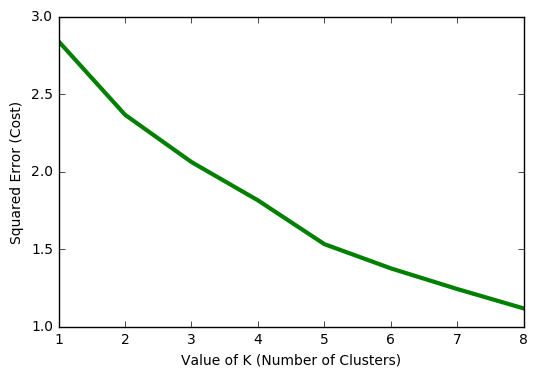

In [42]:
import matplotlib.pyplot as plt  

toronto_grouped_clustering =toronto_grouped.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 9): 
    kmeans = KMeans(init="k-means++", n_clusters = i, n_init=30, max_iter = 1600) 
    kmeans.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(kmeans.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 9), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K (Number of Clusters)") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 

<bk>
NOTE: Using the above plot, the choice of K can be 2 or 5. The better choice for the 
    given data is 5 as per error convergence.

#### Run k-means to cluster the neighborhood into 5 clusters.

In [43]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering =toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=16, random_state=None).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood.

In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Pub,Park,Café,Bakery,Mexican Restaurant,Restaurant,Breakfast Spot,Event Space,Hotel
1,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,Coffee Shop,Gym,Park,Burrito Place,Beer Bar,Italian Restaurant,Sandwich Place,Salad Place,Juice Bar,Restaurant
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Diner,Bubble Tea Shop,Ice Cream Shop,Pizza Place,Bakery
3,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Cocktail Bar,Cosmetics Shop,American Restaurant,Clothing Store,Hotel,Breakfast Spot,Bakery
4,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
5,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Steakhouse,Café,Cheese Shop,Beer Bar,Bakery,Breakfast Spot
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Ice Cream Shop,Juice Bar,Burger Joint,Japanese Restaurant,Bar,Salad Place
7,Downtown Toronto,Christie,43.669542,-79.422564,1,Grocery Store,Café,Park,Candy Store,Baby Store,Coffee Shop,Gas Station,Nightclub,Restaurant,Diner
8,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,1,Coffee Shop,Café,Steakhouse,Thai Restaurant,Bar,Cosmetics Shop,Bakery,Restaurant,Breakfast Spot,Asian Restaurant
9,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,1,Pharmacy,Bakery,Park,Café,Supermarket,Brazilian Restaurant,Recording Studio,Middle Eastern Restaurant,Fast Food Restaurant,Bar


#### Visualize the Resulting Clusters
Use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Examine Clusters

#### Cluster 1

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,The Beaches,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Cluster 2

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Harbourfront,Coffee Shop,Pub,Park,Café,Bakery,Mexican Restaurant,Restaurant,Breakfast Spot,Event Space,Hotel
1,Queen's Park,Coffee Shop,Gym,Park,Burrito Place,Beer Bar,Italian Restaurant,Sandwich Place,Salad Place,Juice Bar,Restaurant
2,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Diner,Bubble Tea Shop,Ice Cream Shop,Pizza Place,Bakery
3,St. James Town,Coffee Shop,Café,Restaurant,Cocktail Bar,Cosmetics Shop,American Restaurant,Clothing Store,Hotel,Breakfast Spot,Bakery
5,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Steakhouse,Café,Cheese Shop,Beer Bar,Bakery,Breakfast Spot
6,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Ice Cream Shop,Juice Bar,Burger Joint,Japanese Restaurant,Bar,Salad Place
7,Christie,Grocery Store,Café,Park,Candy Store,Baby Store,Coffee Shop,Gas Station,Nightclub,Restaurant,Diner
8,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,Bar,Cosmetics Shop,Bakery,Restaurant,Breakfast Spot,Asian Restaurant
9,"Dovercourt Village, Dufferin",Pharmacy,Bakery,Park,Café,Supermarket,Brazilian Restaurant,Recording Studio,Middle Eastern Restaurant,Fast Food Restaurant,Bar
10,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Italian Restaurant,Café,Hotel,Restaurant,Fried Chicken Joint,Scenic Lookout,Brewery,Sporting Goods Shop


#### Cluster 3

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",Park,Playground,Tennis Court,Restaurant,Cuban Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner
33,Rosedale,Park,Playground,Trail,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


#### Cluster 4

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North, Forest Hill West",Bus Line,Jewelry Store,Trail,Sushi Restaurant,Women's Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Cluster 5

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,Health & Beauty Service,Pool,Garden,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Narrow down to most interested neighobords based upon user priority
The ideal neighborhood is close to public transportations, easy access to outdoors and arts, in addition close to university
and common access to daily life need.

Currently there are 229 venue categories but some of them are similar so for simplicity and clarity 
group them to be higher level categories of interests as follows:

1. Cafe_Coffee - keywords (Coffee Shop|Cafe|Bakery|Breakfast|Sandwich)
2. Restaurants - keywords (Restaurant|Sushi)
3. Fitness - keywords (Yoga|Gym|Dance Studio|Sports|Fitness)
4. Outdoors - keywords (Park|Trail|Field|Garden)
5. Arts - keywords (Art|Museum|Gallery|Paintings|Sculpture)
6. General - keywords(Supermarket|Grocery|Shopping|Hospital|Clinic|Salon)
7. Transportation - keywords (Metro|Bus|Train|Boat)

In [58]:
pd.options.mode.chained_assignment = None

g1 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Coffee Shop|Cafe|Bakery|Breakfast|Sandwich')]
g1['sum1'] = g1.sum(axis=1)

g2 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Restaurant|Sushi')]
g2['sum2'] = g2.sum(axis=1)

g3 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Yoga|Gym|Dance Studio|Sports|Fitness')]
g3['sum3'] = g3.sum(axis=1)

g4 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Park|Trail|Field|Garden')]
g4['sum4'] = g4.sum(axis=1)

g5 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Art|Museum|Gallery|Paintings|Sculpture')]
g5['sum5'] = g5.sum(axis=1)

g6 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Supermarket|Grocery|Shopping|Hospital|Clinic|Salon')]
g6['sum6'] = g6.sum(axis=1)

g7 = toronto_grouped.loc[:, toronto_grouped.columns.str.contains('Metro|Bus|Train|Boat')]
g7['sum7'] = g7.sum(axis=1)

#### Create a new dataframe based upon 7 higher level categories of interests

In [60]:
toronto_grouped['Cafe_Coffee'] = g1['sum1']
toronto_grouped['Restaurant'] = g2['sum2']
toronto_grouped['Fitness'] = g3['sum3']
toronto_grouped['Outdoors'] = g4['sum4']
toronto_grouped['Arts'] = g5['sum5']
toronto_grouped['General'] = g6['sum6']
toronto_grouped['Transporation'] = g7['sum7']

#toronto_grouped.set_index('Neighborhood', inplace=True)
toronto_large_grouped = toronto_grouped[['Cafe_Coffee',
                                    'Restaurant',
                                    'Fitness',
                                    'Outdoors',
                                    'Arts',
                                    'General',
                                    'Transporation']].copy()

#### Check and confirm the size of this new broad categories grouped dataframe

In [61]:
toronto_large_grouped.shape

(39, 7)

In [62]:
toronto_large_grouped.reset_index(level=0,inplace=True)
toronto_large_grouped.head()

,Neighborhood,Cafe_Coffee,Restaurant,Fitness,Outdoors,Arts,General,Transporation
0,"Adelaide, King, Richmond",0.260000,0.510000,0.06,0.000000,0.020000,0.010000,0.0000
1,Berczy Park,0.254545,0.381818,0.00,0.018182,0.072727,0.018182,0.0000
2,"Brockton, Exhibition Place, Parkdale Village",0.416667,0.125000,0.25,0.000000,0.083333,0.041667,0.0000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.176471,0.00,0.235294,0.000000,0.000000,0.0000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.125000,0.000000,0.00,0.062500,0.125000,0.000000,0.0625


In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 7

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_large_grouped['Neighborhood']

for ind in np.arange(toronto_large_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_large_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted

#### Set my priority of most interested venues categories in sequence

In [64]:
user_priority = [
            {'Venue':'Transporation','Rating':1},
            {'Venue':'Fitness','Rating':2},
            {'Venue':'Outdoors','Rating':3},
            {'Venue':'Arts','Rating':4},
            {'Venue':'Cafe_Coffee','Rating':5},
            {'Venue':'Restaurant','Rating':6},
            {'Venue':'General','Rating':7}
         ] 
user_priority = pd.DataFrame(user_priority) 

In [65]:
user_priority.set_index('Venue', inplace=True)

In [66]:
toronto_large_grouped.set_index('Neighborhood',inplace=True)
#toronto_large_grouped.reset_index(level=0,inplace=True)
toronto_large_grouped.head()

,Cafe_Coffee,Restaurant,Fitness,Outdoors,Arts,General,Transporation
Neighborhood,,,,,,,
"Adelaide, King, Richmond",0.260000,0.510000,0.06,0.000000,0.020000,0.010000,0.0000
Berczy Park,0.254545,0.381818,0.00,0.018182,0.072727,0.018182,0.0000
"Brockton, Exhibition Place, Parkdale Village",0.416667,0.125000,0.25,0.000000,0.083333,0.041667,0.0000
Business Reply Mail Processing Centre 969 Eastern,0.000000,0.176471,0.00,0.235294,0.000000,0.000000,0.0000
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.125000,0.000000,0.00,0.062500,0.125000,0.000000,0.0625


#### Weight in user priority and recommend top 5 neighborhoods 

In [67]:
neigborhood_recomm = ((toronto_large_grouped * user_priority['Rating']).sum(axis=1))/(user_priority['Rating'].sum())

In [68]:
neigborhood_recomm = neigborhood_recomm.sort_values(ascending=False)
neigborhood_recomm.head()

Neighborhood
The Danforth West, Riverdale                 0.217687
Queen's Park                                 0.206960
Central Bay Street                           0.198554
Chinatown, Grange Park, Kensington Market    0.197768
Church and Wellesley                         0.188713
dtype: float64